# Convolutional Neural Network (CNN)
- CNN is a specialized type of ANN designed primary for processing grid-like data, such as images.
- Neurons in ANN are typically **fully connected** whereas CNN contains multiple layers such as:
  - convolutional layers,
  - pooling layers,
  - and a final fully connected layers.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Convert MNIST image file into a 4d tensor (# of images, height, width, color channel)
transform = transforms.ToTensor()

In [ ]:
# Train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
train_data

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.62MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
# Create a small batch size for images (e.g. 10)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Sample Model
We're not building out a real model in this part of the code. This section is just to have further understanding of the inputs and outputs in each of the convolutional and pooling layers.

In [ ]:
# Define our CNN model
## 2 convolution layers:
## one with some arbituary parameters: 1 input, 6 outputs, 3x3 kernel size and stride length of 1
## the other with 6 inputs (because 6 outputs from the prev layer), 16 outputs, 3x3 kernel and stride 1
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [ ]:
# Grab 1 MNIST image
for i, (X_train, y_train) in enumerate(train_data):
  break

X_train.shape

torch.Size([1, 28, 28])

In [ ]:
x = X_train.view(1,1,28,28) # 1 batch, 1 image, 28x28 dimension

In [ ]:
# Perform first convolution
x = F.relu(conv1(x))
x.shape
# 28x28 became 26x26 because we didn't specify padding, which is fine because the outer parameter pixels are useless anyways
# 1 image, 6 feature maps (as specified in the conv1 command)

torch.Size([1, 6, 26, 26])

In [ ]:
# Pass through pooling layer with kernel size 2 and stride 2
x = F.max_pool2d(x, 2, 2)
x.shape # 26x26 became 13x13 because we pooled with a 2x2 kernel

torch.Size([1, 6, 13, 13])

In [ ]:
# Perform second convolution
x = F.relu(conv2(x))
x.shape # lose 2 pixels around parameter because we didn't set padding again

torch.Size([1, 16, 11, 11])

In [ ]:
# Pass through 2nd pooling layer
x = F.max_pool2d(x, 2, 2)
x.shape # 11/2 = 5.5 but we have to round down because we can't invent data to round up

torch.Size([1, 16, 5, 5])

# Building CNN Model

In [ ]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully connected layers
    self.fc1 = nn.Linear(5*5*16, 120) # 5x5x16 is obtained from the previous line of code, flatten it to 120 neurons (arbituary)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) # Has to end with 10 because we have 10 predicted classes (numbers 0 to 9)

  # Forward function
  def forward(self, X):
    # First pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2
    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernel and stride 2

    # Re-view to flatten it out
    X = X.view(-1, 16*5*5) # -1 so that we can vary the batch size

    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X) # no need for relu
    return F.log_softmax(X, dim=1)


In [ ]:
# Create instance of model
torch.manual_seed(123)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller lr = longer training time

In [ ]:
# Training and testing
import time
start_time = time.time()

# Initialize parameters
epochs = 10
train_losses = []
test_losses = []
train_correct =[]
test_correct =[]

for epoch in range(epochs):
  train_corr = 0
  test_corr = 0

  # Training
  for batch, (X_train, y_train) in enumerate(train_loader):
    batch += 1 # start our batch at 1
    y_pred = model(X_train) # get predicted values from the training set
    loss = criterion(y_pred, y_train) # how off are we?

    predicted = torch.max(y_pred.data, 1)[1] # sum up the number of correct predictions
    batch_corr = (predicted == y_train).sum() # sum up number of correct in batch
    train_corr += batch_corr

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print results
    if batch % 600 == 0:
      print(f'Epoch: {epoch}  Batch: {batch}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)


  # Validation
  with torch.no_grad(): # No grad because we do not update weights and biases during testing
    for batch, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

current_time = time.time()
total_time = current_time - start_time
print(f'Training took {total_time/60} minutes')

Epoch: 0  Batch: 600  Loss: 0.2916695475578308
Epoch: 0  Batch: 1200  Loss: 0.2221393585205078
Epoch: 0  Batch: 1800  Loss: 0.19265395402908325
Epoch: 0  Batch: 2400  Loss: 0.11422338336706161
Epoch: 0  Batch: 3000  Loss: 0.057844679802656174
Epoch: 0  Batch: 3600  Loss: 0.12103337049484253
Epoch: 0  Batch: 4200  Loss: 0.6115381121635437
Epoch: 0  Batch: 4800  Loss: 0.27090147137641907
Epoch: 0  Batch: 5400  Loss: 0.005950583145022392
Epoch: 0  Batch: 6000  Loss: 0.02685423195362091
Epoch: 1  Batch: 600  Loss: 0.0329289436340332
Epoch: 1  Batch: 1200  Loss: 0.001332884537987411
Epoch: 1  Batch: 1800  Loss: 0.5471917390823364
Epoch: 1  Batch: 2400  Loss: 0.19841298460960388
Epoch: 1  Batch: 3000  Loss: 0.0006914833793416619
Epoch: 1  Batch: 3600  Loss: 0.014250378124415874
Epoch: 1  Batch: 4200  Loss: 0.007611897774040699
Epoch: 1  Batch: 4800  Loss: 0.013124721124768257
Epoch: 1  Batch: 5400  Loss: 0.06777409464120865
Epoch: 1  Batch: 6000  Loss: 0.04506794735789299
Epoch: 2  Batch: 60

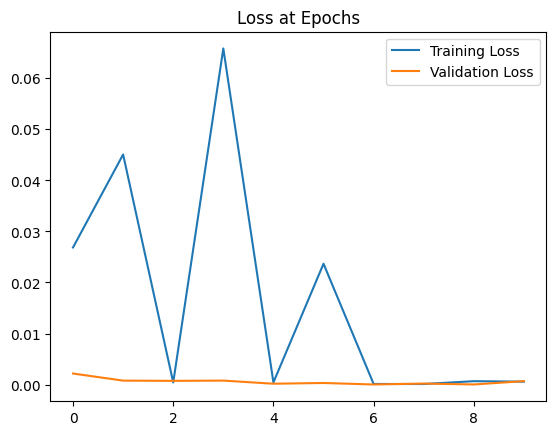

In [ ]:
# Graph loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at Epochs')
plt.legend()

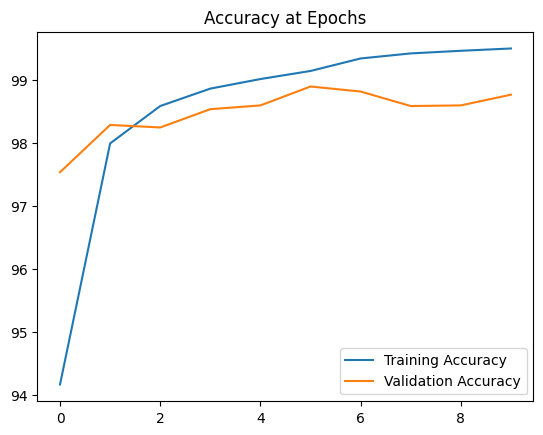

In [ ]:
# Graph accuracy at end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at Epochs')
plt.legend()

In [ ]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
# Test
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
# Check accuracy
correct.item()/len(test_data)*100

98.76

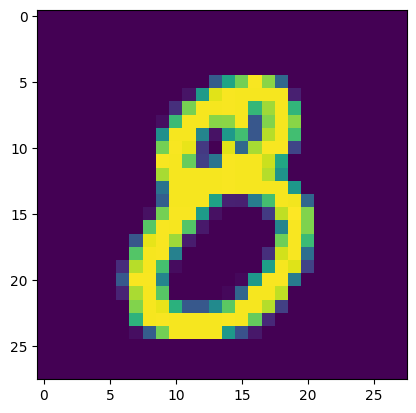

In [ ]:
# Predict a new image
new_image = test_data[4145][0].reshape(28,28)
plt.imshow(new_image) # model should output '8'

In [ ]:
# Pass image through model
model.eval() # switch the model to evaluation mode instead of training mode
with torch.no_grad():
  new_prediction = model(new_image.view(1,1,28,28)) # batch size 1, color channel 1, and 28x28 dimension

In [ ]:
# Check new prediction (tensor with highest probability)
new_prediction.argmax() # Correct!

tensor(8)